In [1]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [4]:
'''
column 1: group ID
column 2: richness
column 3: ra
column 4: dec
column 5: redshift
column 6: log M_h/(M_sun/h)
column 7: L_group (10^10Lsun/h/h)
'''
dgroup = np.loadtxt('../odata/CLAUDS_HSC_iband_group')
d2 = np.loadtxt('../odata/iCLAUDS_HSC_iband_2')
digal = np.loadtxt('../odata/CLAUDS_HSC_iband_igal')

In [2]:
'''
plot group images
#------------------
idx_group: idx of group in xxx_group file
path_image: the path to input image file
out_image: the path to output image file
'''

def find_image(zregion,nm,groupid):
    from astropy.wcs import WCS
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import glob
    import numpy as np
    
    idx_group = np.where((dgroup[:,4] > zregion[0]) & (dgroup[:,4] <= zregion[1]) & (dgroup[:,1] >= nm))[0]
    nchoose = np.where(groupid == dgroup[idx_group,0])[0]
    path_image = '../data/images/HSC_group_z%s-%s' %(zregion[0],zregion[1])
    filename0 = glob.glob(path_image+'/%s-cutout-HSC-*' %int(nchoose+2))
    print(nchoose+2)
    print(filename0)
    if len(filename0) < 1:
        print('No this group image')
    image_file = get_pkg_data_filename(filename0[0])
    print(fits.getdata(image_file, ext=0).shape)

    hdu = fits.open(image_file)
    wcs = WCS(hdu[1].header)
    return wcs

def plot_one_group(zregion,nm,groupid,ax,mapmin,mapmax):
    from astropy.wcs import WCS
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import glob
    import numpy as np
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    #choose image pathe
    idx_group = np.where((dgroup[:,4] > zregion[0]) & (dgroup[:,4] <= zregion[1]) & (dgroup[:,1] >= nm))[0]
    
    gidall = dgroup[idx_group,0]
    nchoose = np.where(groupid == dgroup[idx_group,0])[0]
    Ng = idx_group.shape[0]
    
    #prepare group and member galaxy information
    nclu = int(dgroup[idx_group[nchoose],0])
    print("The group id is ", nclu)
    clu_ra = dgroup[nclu-1,2]
    clu_dec = dgroup[nclu-1,3]
    clu_redz = dgroup[nclu-1,4]
    clu_Mh = dgroup[nclu-1,-2].round(2)
    print(clu_ra, clu_dec)
    
    idx_gal = np.where(d2[:,0] == nclu)[0]
    galid = np.int64(d2[idx_gal,1])
    ra_gal = digal[galid - 1, 1]
    dec_gal = digal[galid - 1, 2]
    redz_gal = digal[galid - 1, 3].round(2)

    #galaxis around group center
    dra = 0.0055
    ddec = 0.0055
    idx_region = np.where((clu_ra > digal[:,1] - dra) & (clu_ra < digal[:,1] + dra) & 
                          (clu_dec > digal[:,2] - ddec) & (clu_dec < digal[:,2] + ddec))[0] 

    ra_reg = digal[idx_region,1]
    dec_reg = digal[idx_region,2]
    redz_reg = digal[idx_region,3]

    print(ra_reg.shape)

    #prepare group r180 
    import linecache
    fprop = '../odata/CLAUDS_HSC_iband_prop'
    nline = 1+(nclu-1)*6
    gprop = linecache.getline(fprop,nline)
    phyp = [float(prop) for prop in gprop.split()]
    r180 = phyp[-2] #unit:Mpc/h
    
    #=====================================================================
    #begin plot
    # image_file = get_pkg_data_filename('../../images_HSC_CLAUDS/Deep/calexp-HSC-I-17270-1,8.fits')
    # image_file = get_pkg_data_filename('../data/images/cutout-HSC-I-17406-pdr2_dud-210625-033129.fits')
    path_image = '../data/images/HSC_group_z%s-%s' %(zregion[0],zregion[1])
    filename0 = glob.glob(path_image+'/%s-*' %int(nchoose+2))
    if len(filename0) <1:
        print('No this group image')
    image_file = get_pkg_data_filename(filename0[0])
    print(fits.getdata(image_file, ext=0).shape)

    hdu = fits.open(image_file)
    ax.imshow(hdu[1].data, cmap = 'Greys', vmax = mapmax, vmin = mapmin, origin='lower')

    #plot center
    cen = wcs.wcs_world2pix(clu_ra, clu_dec, 0)
    ax.plot(cen[0],cen[1],'*',c  = 'r',zorder = 6,label = 'center: $z$ = %s' %clu_redz.round(2))

    #plot around galaxies
    sc2 = ax.scatter(ra_reg, dec_reg,transform=ax.get_transform('world'), s = 100, c = redz_reg,
             cmap = 'jet', zorder = 5, vmin = 0, vmax = 6)
    sc2.set_facecolor('none')

#     #set colorbar
#     cax = plt.axes([0.90, 0.12, 0.035, 0.76])
#     fig.colorbar(sc2,cax = cax, shrink = 0.72,label = 'redshift')

    #text redshift 
    galreg = wcs.wcs_world2pix(ra_reg, dec_reg, 0)
    for i in range(ra_reg.shape[0]):
        if galreg[0][i] > cen[0]-108 and galreg[0][i] < cen[0]+108 and galreg[1][i] < cen[1]+108 and galreg[1][i] > cen[1]-108:
            plt.text(ra_reg[i]-1e-4, dec_reg[i]+1e-4, str(redz_reg[i].round(2)), fontsize = 6,
                 transform=ax.get_transform('world'),zorder = 5)

    #plot member galaxy
    ax.plot(ra_gal, dec_gal, 's', transform=ax.get_transform('world'),
            mfc='none',mec= 'r', ms = 13, lw = 1.5, zorder = 5, label = 'members: $N_\mathrm{g}$ = %s' %ra_gal.shape[0])

    #plot group region with r180
    #convert r180 to deg
    from astropy.cosmology import FlatLambdaCDM
    import numpy as np
    cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315)
    d_A = cosmo.comoving_distance(z=clu_redz) * 0.674
    r180u =  r180 * u.Mpc
    theta_radian = (r180u / d_A).to(u.degree, u.dimensionless_angles()).value # unit is Mpc only now
    print(theta_radian)
    from matplotlib.patches import Circle
    regr180 = Circle((clu_ra, clu_dec), theta_radian, ec='magenta', ls = '--', lw = 1.5, fc='none', zorder = 5,
               transform=ax.get_transform('world'),
                     label = '$r_{180}= %s\ h^{-1}\mathrm{Mpc}$ \n$\mathrm{log} M_\mathrm{h}\ [h^{-1} \mathrm{M_{\odot}]= %s}$' %(np.round(r180,2),np.round(clu_Mh,2)))
    ax.add_patch(regr180)

    #set xlabel
    ax.coords.grid('icrs',color = 'none')
    ax.coords[0].set_axislabel('RA')
    ax.coords[1].set_axislabel('Dec')
    ax.coords[0].set_ticklabel(size="small")
    ax.coords[1].set_ticklabel(size="small")

    lon = ax.coords[0]
    lon.set_major_formatter('d.ddd')
    lat = ax.coords[1]
    lat.set_major_formatter('d.ddd')
    lat.set_ticks_position('l')
    lon.set_ticks_position('b')
    
    #set image range 
#     cenlow = wcs.wcs_world2pix(clu_ra+0.0055, clu_dec-0.0055, 0)
#     cenhigh = wcs.wcs_world2pix(clu_ra-0.0055, clu_dec+0.0055, 0)
#     ax.set_xlim(cenlow[0],cenhigh[0])
#     ax.set_ylim(cenlow[1],cenhigh[1])
    ax.set_xlim(cen[0]-120,cen[0]+120)
    ax.set_ylim(cen[1]-120,cen[1]+120)
    ax.legend(fontsize = 'x-small', loc = 1,shadow = True)

#     plt.subplots_adjust(bottom=0.02, right=0.88, top=0.98)
        

<IPython.core.display.Javascript object>


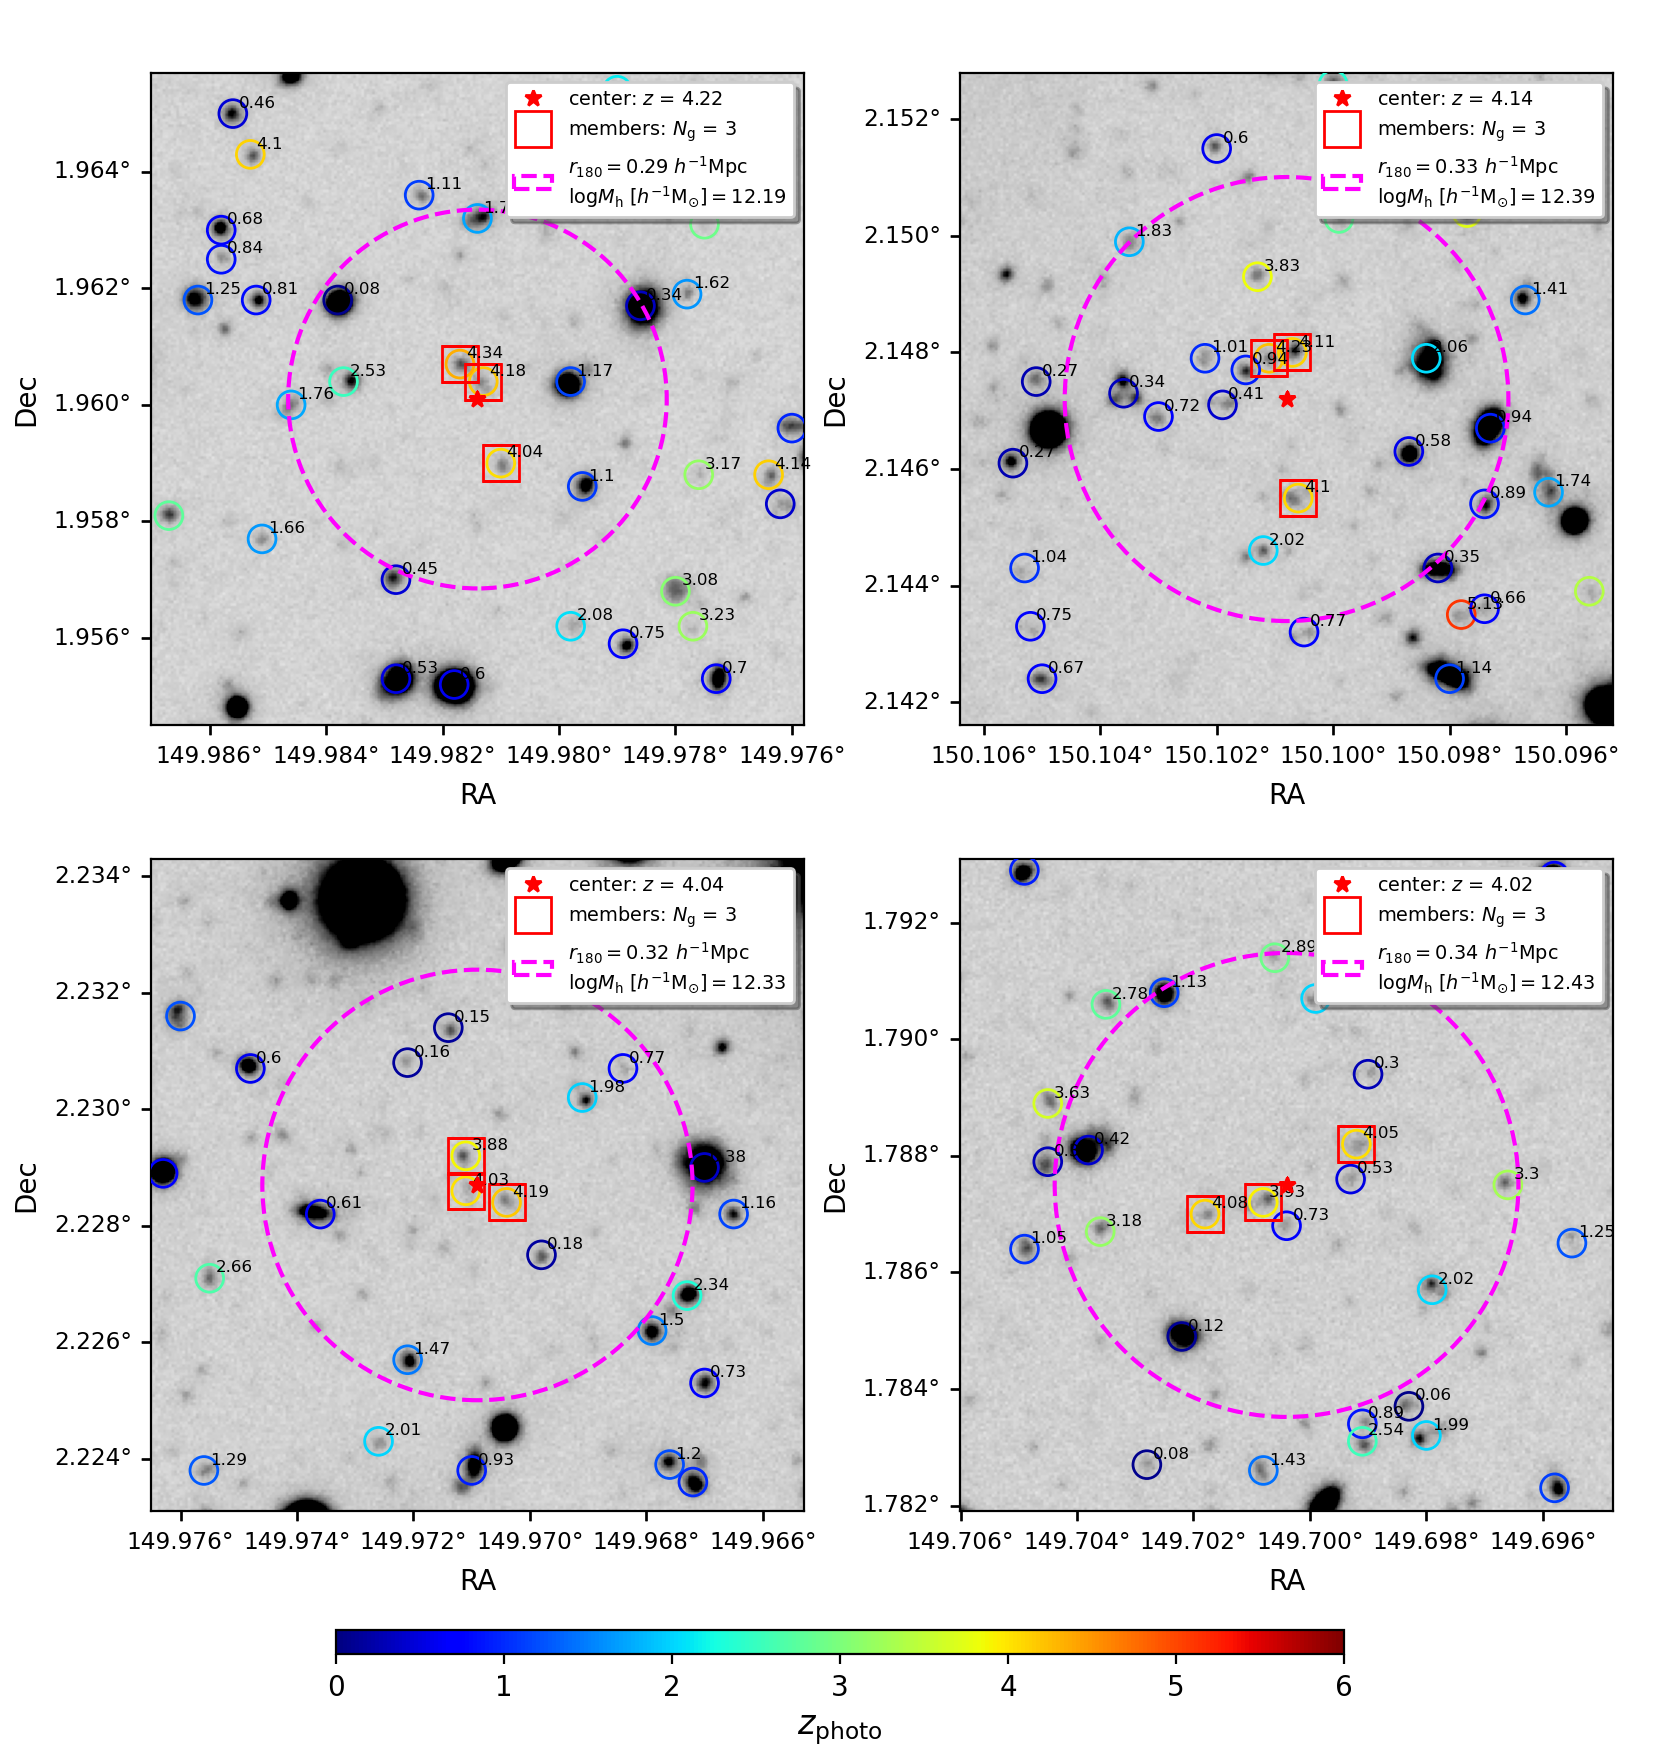

[17]
['../data/images/HSC_group_z4.0-4.4/17-cutout-HSC-I-9813-pdr2_dud.fits']
(3429, 3430)
The group id is  307502
149.9814 1.9601
(36,)
(3429, 3430)
0.003250773593614254
[18]
['../data/images/HSC_group_z4.0-4.4/18-cutout-HSC-I-9813-pdr2_dud.fits']
(3429, 3430)
The group id is  308435
150.1008 2.1472
(36,)
(3429, 3430)
0.0038104643038500714
[19]
['../data/images/HSC_group_z4.0-4.4/19-cutout-HSC-I-9813-pdr2_dud.fits']
(3429, 3431)
The group id is  308715
149.9709 2.2287
(24,)
(3429, 3431)
0.0036951337189850505
[23]
['../data/images/HSC_group_z4.0-4.4/23-cutout-HSC-I-9813-pdr2_dud.fits']
(3429, 3431)
The group id is  321925
149.7004 1.7875
(28,)
(3429, 3431)
0.003981272416118969


In [5]:
fig = plt.figure(figsize = (8.4,8.8))

nm = 3

groupid = 307502
zregion = [4.0,4.4]
wcs = find_image(zregion,nm,groupid)
ax = fig.add_subplot(221,projection=wcs)
mapmax = 0.26; mapmin = -0.1;
plot_one_group(zregion,nm,groupid,ax,mapmin,mapmax)

groupid = 308435
zregion = [4.0,4.4]
wcs = find_image(zregion,nm,groupid)
ax = fig.add_subplot(222,projection=wcs)
mapmax = 0.25; mapmin = -0.1;
plot_one_group(zregion,nm,groupid,ax,mapmin,mapmax)

groupid = 308715
zregion = [4.0,4.4]
wcs = find_image(zregion,nm,groupid)
ax = fig.add_subplot(223,projection=wcs)
mapmax = 0.25; mapmin = -0.1;
plot_one_group(zregion,nm,groupid,ax,mapmin,mapmax)

groupid = 321925
zregion = [4.0,4.4]
wcs = find_image(zregion,nm,groupid)
ax = fig.add_subplot(224,projection=wcs)
mapmax = 0.25; mapmin = -0.1;
plot_one_group(zregion,nm,groupid,ax,mapmin,mapmax)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=6)
plt.subplots_adjust(top=0.98,left = 0.09, right = 0.96, bottom = 0.12,hspace = 0.08,wspace = 0.24)
cax = plt.axes([0.2, 0.06, 0.6, 0.014])
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation = 'horizontal')
cbar.set_label(label = '$z_\mathrm{photo}$', fontsize = 12)

plt.show()
# plt.tight_layout()

plt.savefig('../figs/triples.pdf')

In [ ]:
# zregion = [5.6,6.0]; nm = 2;
# #select with redshift and richness
# idx_group = np.where((dgroup[:,4] > zregion[0]) & (dgroup[:,4] <= zregion[1]) & (dgroup[:,1] >= nm))[0]
# print('group id are ', np.int64(dgroup[idx_group,0]))